# PHY 480/905 Semester Project
---

**Project Title:** Computationally Modeling and Optimizing a Tuned Mass Damper <br>
**Project Authors:** Patrick Tutt & Steven VanCamp <br>
**Last Updated:** 27/4/23 <br>

# Intro
---

# Methodology
---

# 1) Code
---

In [1]:
import numpy as np
import numpy.random as npr
import pandas as pds
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.spatial import cKDTree

## 1.1) Model 1: Coupled Spring Masses
---

### 1.1.1) Simulation Results

In [2]:
%%bash
fname_res="../results/sim_spring_res.txt"

mass_building=10.0
mass_dampner=0.3

k_building=8.0
k_dampner=3.0

fr_building=0.2
fr_dampner=0.8

run_time=20.0

g++ -O3 -o sim_spring.exe ../src/sim_spring.cpp

./sim_spring.exe $fname_res $mass_building $mass_dampner $run_time

rm sim_spring.exe

Text(0, 0.5, 'Mass Position [m]')

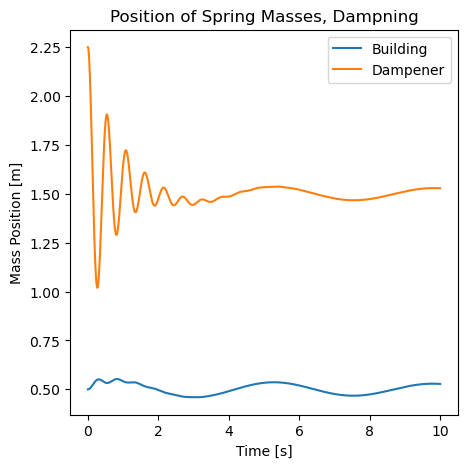

In [3]:
data_tmd = np.genfromtxt('../results/sim_spring_res.txt', dtype='f8', delimiter=',', usecols=[0,1,2,3])

data_range = np.linspace(0,10, len(data_tmd[:,0]))

fig, ax1 = plt.subplots()
fig.set_size_inches(5,5)

ax1.plot(data_range, data_tmd[:,0], label='Building')
ax1.plot(data_range, data_tmd[:,2], label='Dampener')

ax1.legend()

ax1.set_title('Position of Spring Masses, Dampning')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Mass Position [m]')

## 1.2) Model 2: Building
---

### 1.2.1) Simulation Results

In [4]:
%%bash
fname_seis_data="../init_conds/elcentro_NS.dat.txt"
fname_init_conds="../init_conds/init_cond_build.txt"
fname_init_conds_no_damp="../init_conds/init_cond_build_no_damp.txt"
fname_damp_res="../results/sim_build_res_damp.txt"
fname_no_damp_res="../results/sim_build_res_no_damp.txt"

rm $fname_damp_res
rm $fname_no_damp_res

g++ -O3 -o sim_building.exe ../src/sim_building.cpp

./sim_building.exe $fname_init_conds $fname_seis_data $fname_damp_res
./sim_building.exe $fname_init_conds_no_damp $fname_seis_data $fname_no_damp_res

rm sim_building.exe

In [5]:
quake_data = np.genfromtxt('../init_conds/elcentro_NS.dat.txt', delimiter=' ', usecols=(0,1), dtype='f8')

data_damp = np.genfromtxt('../results/sim_build_res_damp.txt', delimiter=',', skip_header=1, dtype='f8')
data_no_damp = np.genfromtxt('../results/sim_build_res_no_damp.txt', delimiter=',', skip_header=1, dtype='f8')

data_damp = data_damp[:,:-1]
data_no_damp = data_no_damp[:,:-1]

Text(0.5, 1.0, 'Force Applied On The Ground Floor Over Time')

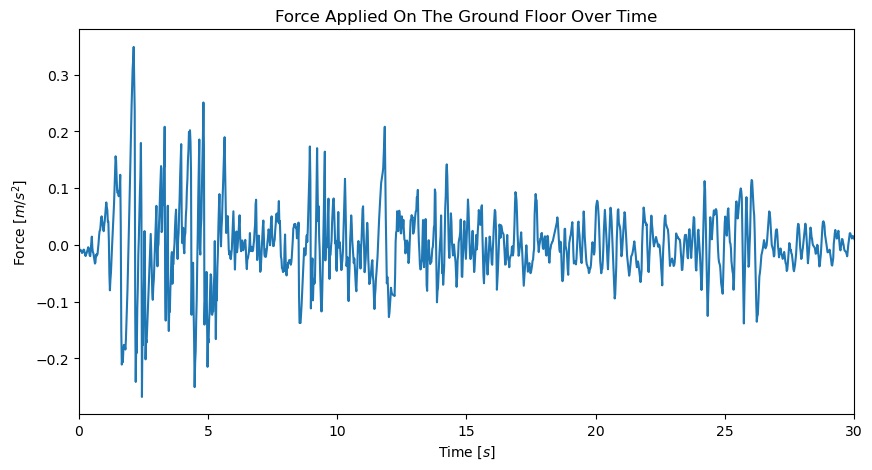

In [6]:
fig, ax1 = plt.subplots()
fig.set_size_inches(10,5)

# plot input seismic signal/data
ax1.plot(quake_data[:,0], quake_data[:,1])

ax1.set_xlim(0,30)

ax1.set_xlabel('Time [$s$]')
ax1.set_ylabel('Force [$m/s^{2}$]')
ax1.set_title('Force Applied On The Ground Floor Over Time')

Text(0.5, 1.0, '1D Displacement Of Each Floor')

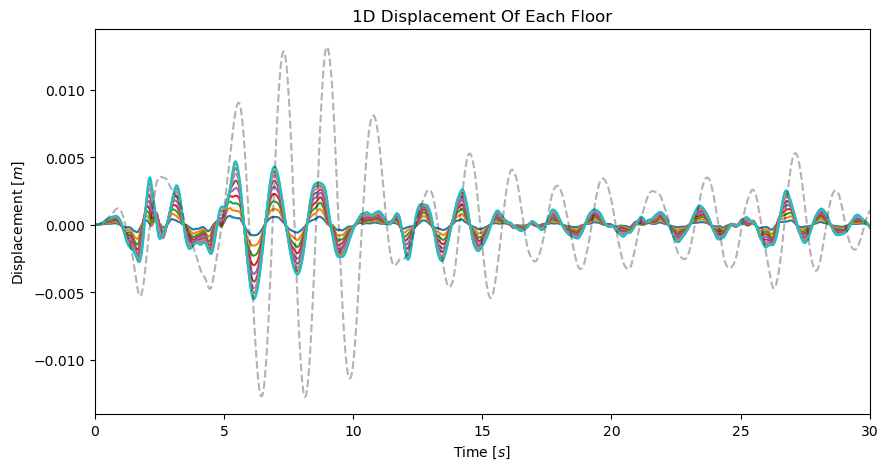

In [7]:
fig, ax1 = plt.subplots()
fig.set_size_inches(10,5)

# plot floor displacement
for i in range(len(data_damp[0])-2):
    if (i%2 == 0):
        ax1.plot(quake_data[:,0], data_damp[:,i], label=f'Floor {i/2}')

ax1.plot(quake_data[:,0], data_damp[:,len(data_damp[0])-2], 
         label='Dampener', c='black', linestyle='--', alpha=0.3)

ax1.set_xlim(0,30)

# ax1.legend()

ax1.set_xlabel('Time [$s$]')
ax1.set_ylabel('Displacement [$m$]')
ax1.set_title('1D Displacement Of Each Floor')

Text(0.5, 1.0, '1D Displacement Of Each Floor')

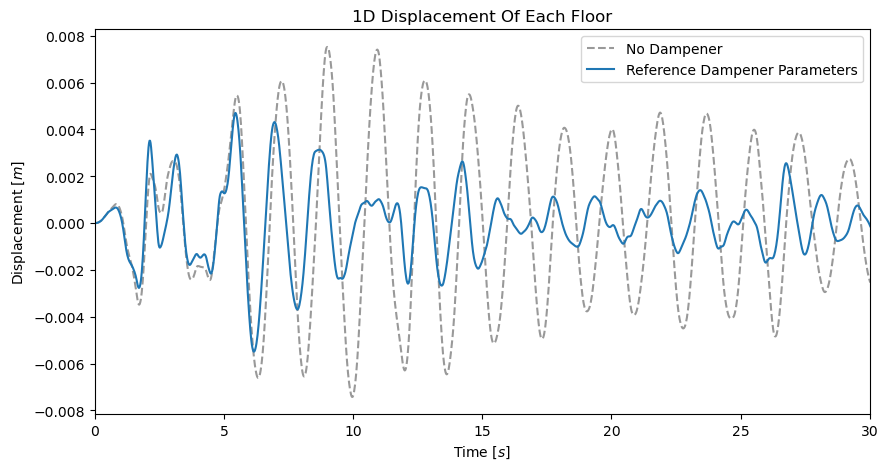

In [8]:
fig, ax1 = plt.subplots()
fig.set_size_inches(10,5)

# plot top floor displacement for the cases where there is dampenign and low dampening
ax1.plot(quake_data[:,0], data_no_damp[:,len(data_no_damp[0])-4], 
         label=f'No Dampener', alpha=0.4, color='black',
         linestyle='--')

ax1.plot(quake_data[:,0], data_damp[:,len(data_damp[0])-4], 
         label=f'Reference Dampener Parameters')

ax1.set_xlim(0,30)

ax1.legend()

ax1.set_xlabel('Time [$s$]')
ax1.set_ylabel('Displacement [$m$]')
ax1.set_title('1D Displacement Of Each Floor')

### 1.2.2) Optimization Results

#### Generate and load MCMC results

In [9]:
%%bash
fname_init_conds="../init_conds/init_cond_build.txt"
fname_xg_data="../init_conds/elcentro_NS.dat.txt"
fname_optim_conds="../init_conds/init_cond_optim.txt"
fname_output="../results/optim_build_mcmc.txt"

rm $fname_output
rm "../results/mcmc_log.txt"

g++ -O3 -o optim_building.exe ../src/optim_building.cpp

./optim_building.exe $fname_init_conds $fname_xg_data $fname_optim_conds $fname_output

rm optim_building.exe

In [10]:
mcmc_data = np.genfromtxt('../results/optim_build_mcmc.txt', delimiter=', ', dtype='f8')

m = mcmc_data[:,0]
k = mcmc_data[:,1]
c = mcmc_data[:,2]

#### Compare prior assumptions to results

In [11]:
def gaus_prior(x, prior, sigma):
    y = (2*np.pi*sigma)**(-0.5) * np.exp((x-prior)**(2) / (2*sigma)**(2))

    return y

n_x = 1000

m_a, m_b = 0.0, 0.2
m_prior_range = np.linspace(m_a, m_b, n_x)
m_prior = gaus_prior(m_prior_range, 0.05, 0.03)

k_a, k_b = 1.5, 3.5
k_prior_range = np.linspace(k_a, k_b, n_x)
k_prior = gaus_prior(k_prior_range, 3.7, 1.5)

c_a, c_b = 0.0, 0.7
c_prior_range = np.linspace(c_a, c_b, n_x)
c_prior = gaus_prior(c_prior_range, 0.197, 0.10)

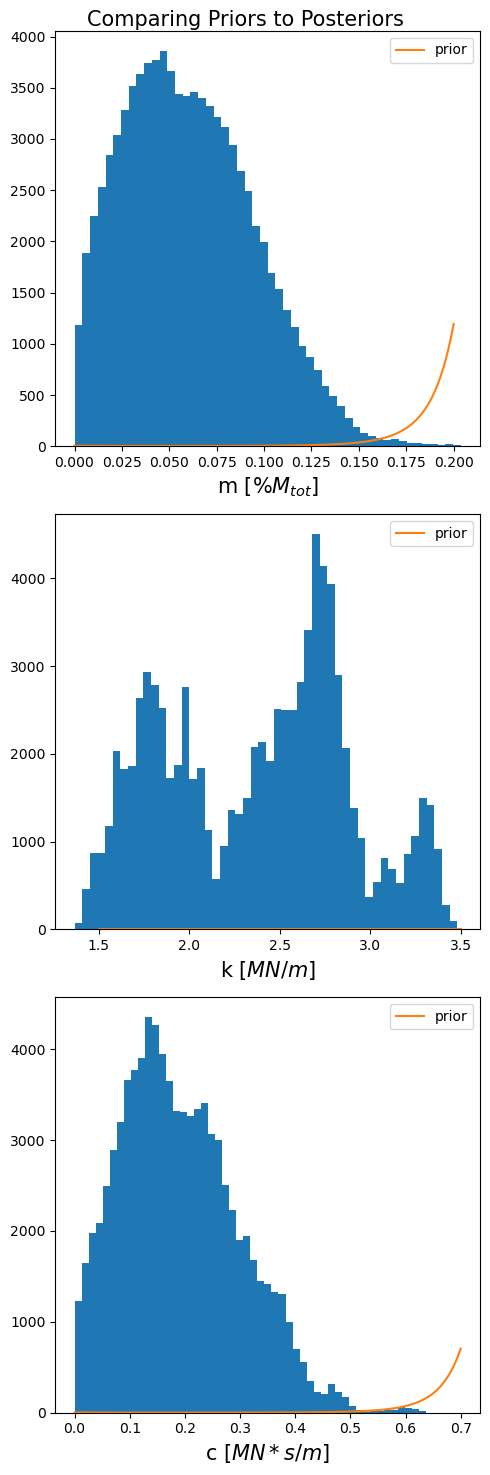

In [12]:
n_bins = 50
f_size = 15
orien = 'vertical'

fig, ax = plt.subplots(3,1)
fig.set_size_inches(5,15)

fig.suptitle("Comparing Priors to Posteriors", fontsize=f_size)

# setup labels
ax[0].set_xlabel('m $[\%M_{tot}]$', fontsize=f_size)
ax[1].set_xlabel('k $[MN/m]$', fontsize=f_size)
ax[2].set_xlabel('c $[MN*s/m]$', fontsize=f_size)

# plot triangle plot
ax[0].hist(m, bins=n_bins, orientation=orien)
ax[0].plot(m_prior_range, m_prior, label='prior')
ax[0].legend()

ax[1].hist(k, bins=n_bins, orientation=orien)
ax[1].plot(k_prior_range, k_prior, label='prior')
ax[1].legend()

ax[2].hist(c, bins=n_bins, orientation=orien)
ax[2].plot(c_prior_range, c_prior, label='prior')
ax[2].legend()

fig.tight_layout()


#### Make Triptych plot of optimization parameters

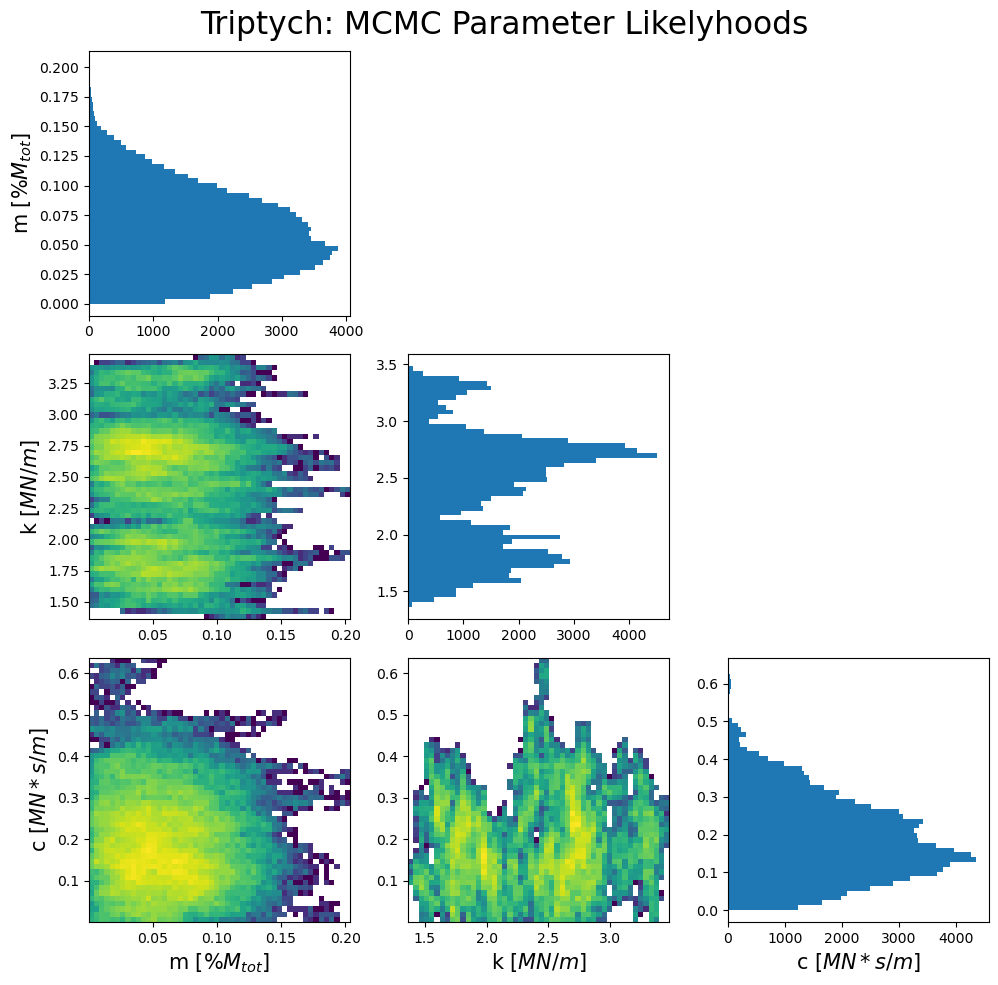

In [13]:
n_bins = 50
f_size = 15
orien = 'horizontal'

fig, ax = plt.subplots(3,3)
fig.set_size_inches(10,10)

fig.suptitle('Triptych: MCMC Parameter Likelyhoods', fontsize=f_size*1.5)

# setup labels
ax[2,0].set_xlabel('m $[\%M_{tot}]$', fontsize=f_size)
ax[2,1].set_xlabel('k $[MN/m]$', fontsize=f_size)
ax[2,2].set_xlabel('c $[MN*s/m]$', fontsize=f_size)

ax[0,0].set_ylabel('m $[\%M_{tot}]$', fontsize=f_size)
ax[1,0].set_ylabel('k $[MN/m]$', fontsize=f_size)
ax[2,0].set_ylabel('c $[MN*s/m]$', fontsize=f_size)

# plot triangle plot
ax[0,0].hist(m, bins=n_bins, orientation=orien)

ax[1,0].hist2d(m, k, bins=n_bins, norm=LogNorm())
ax[1,1].hist(k, bins=n_bins, orientation=orien)

ax[2,0].hist2d(m, c, bins=n_bins, norm=LogNorm())
ax[2,1].hist2d(k, c, bins=n_bins, norm=LogNorm())
ax[2,2].hist(c, bins=n_bins, orientation=orien)

# delete upper triangle
fig.delaxes(ax[0,2])
fig.delaxes(ax[0,1])
fig.delaxes(ax[1,2])

fig.tight_layout()


#### Make 3d volumetric plot of all parameter space

In [14]:
m_min, m_max = np.min(mcmc_data[:,0]), np.max(mcmc_data[:,0])
k_min, k_max = np.min(mcmc_data[:,1]), np.max(mcmc_data[:,1])
c_min, c_max = np.min(mcmc_data[:,2]), np.max(mcmc_data[:,2])

m_range = np.linspace(m_min, m_max, 10)
k_range = np.linspace(k_min, k_max, 10)
c_range = np.linspace(c_min, c_max, 10)

m_grid, k_grid, c_grid = np.meshgrid(m_range, k_range, c_range)

grid_values = np.zeros_like(m_grid).flatten() # grid containing density value for each grid point

grid_tree = np.zeros((len(m_grid.flatten()),3))
grid_tree[:,0] = m_grid.flatten()
grid_tree[:,1] = k_grid.flatten()
grid_tree[:,2] = c_grid.flatten()

grid_point_tree = cKDTree(grid_tree)
true_point_tree = cKDTree(mcmc_data[:,:3])

n_grid_poitns = len(grid_tree)

r_bin = 0.1

kd_search_res = grid_point_tree.query_ball_tree(true_point_tree, r=r_bin)

for i in range(len(kd_search_res)):
    grid_values[i] = len(kd_search_res[i])

grid_values = np.reshape(grid_values, np.shape(m_grid)).flatten()

grid_values = grid_values/np.linalg.norm(grid_values)

#### Get best parameter values from this parameter space

In [15]:
vals_index=np.argwhere(grid_values==grid_values.max())

m_best = grid_tree[vals_index[0,0],0]
k_best = grid_tree[vals_index[0,0],1]
c_best = grid_tree[vals_index[0,0],2]

print('The "best" value for M was:', round(m_best,6))
print('The "best" value for k was:', round(k_best,6))
print('The "best" value for c was:', round(c_best,6))

The "best" value for M was: 0.045323
The "best" value for k was: 2.775897
The "best" value for c was: 0.212485


#### Plot MCMC parameter space in volumetric 3d

In [16]:
fig = go.Figure()

fig.add_trace(
    go.Scatter3d(
        x=[m_best],
        y=[k_best],
        z=[c_best],
        marker=dict(
            size=10
        )
    )
)

fig.add_trace(
    go.Volume(
        x=m_grid.flatten(),
        y=k_grid.flatten(),
        z=c_grid.flatten(),
        value=grid_values,
        opacity=0.1, # needs to be small to see through all surfaces
        surface_count=30, # needs to be a large number for good volume rendering
        colorscale='Viridis'
    )
)

fig.update_layout(
    scene = dict(
        xaxis = dict(title='m [%M_{tot}]'),
        yaxis = dict(title='k [MN/m]'),
        zaxis = dict(title='c [MN*s/m]'),
        aspectmode='cube'
    )
)

fig.show()
fig.write_html('../results/mcmc_scatter.html')

#### Run Building Simulation With "Optimal" Parameters

In [17]:
print('The "best" value for M was:', round(m_best,6))
print('The "best" value for k was:', round(k_best,6))
print('The "best" value for c was:', round(c_best,6))

The "best" value for M was: 0.045323
The "best" value for k was: 2.775897
The "best" value for c was: 0.212485


In [18]:
%%bash
fname_init_conds="../init_conds/init_cond_build.txt"
fname_seis_data="../init_conds/elcentro_NS.dat.txt"
fname_damp_optim="../results/sim_build_res_optim.txt"

rm $fname_damp_optim

# "damp_m_perc" represents what percent the total building mass will 
# be multiplied by to get the mass of the dampener
damp_m=0.068067
damp_k=2.781683
damp_c=0.208384

g++ -O3 -o sim_building.exe ../src/sim_building.cpp

./sim_building.exe $fname_init_conds $fname_seis_data $fname_damp_optim \
                   $damp_m $damp_k $damp_c

rm sim_building.exe

In [19]:
data_optim = np.genfromtxt('../results/sim_build_res_optim.txt', delimiter=',', skip_header=1, dtype='f8')

data_optim = data_optim[:,:-1]

Text(0.5, 1.0, '1D Displacement of The Top Floor')

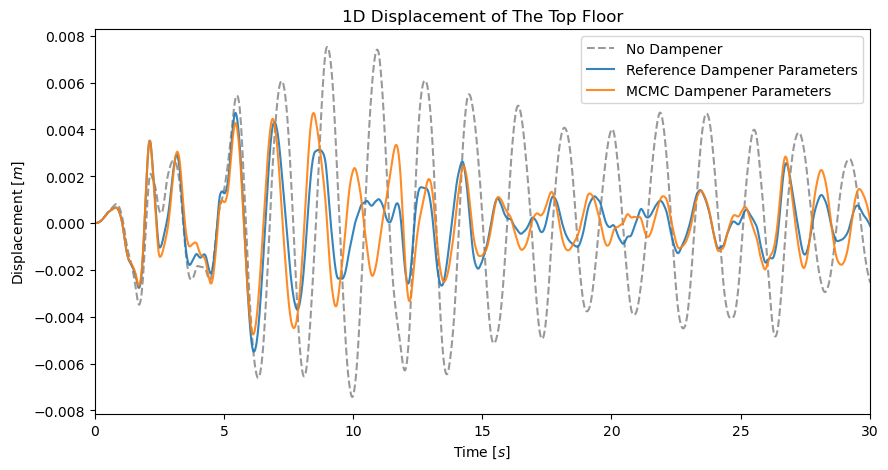

In [20]:
fig, ax1 = plt.subplots()
fig.set_size_inches(10,5)

# plot top floor displacement for the cases where there is dampenign and low dampening
ax1.plot(quake_data[:,0], data_no_damp[:,len(data_no_damp[0])-4], 
         label=f'No Dampener', alpha=0.4, color='black',
         linestyle='--')

ax1.plot(quake_data[:,0], data_damp[:,len(data_damp[0])-4], 
         label=f'Reference Dampener Parameters', alpha=0.9)

ax1.plot(quake_data[:,0], data_optim[:,len(data_optim[0])-4], 
         label=f'MCMC Dampener Parameters', alpha=0.9)

ax1.set_xlim(0,30)

ax1.legend()

ax1.set_xlabel('Time [$s$]')
ax1.set_ylabel('Displacement [$m$]')
ax1.set_title('1D Displacement of The Top Floor')